# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy_scripts as ss

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = ss.lib.expression_colormap()

# Processing

### macparland18

In [2]:
ad = sc.read_csv('GSE115469_Data.csv')

In [3]:
ad = ad.T

In [4]:
ad.X = sp.csr_matrix(ad.X)

In [5]:
ad

AnnData object with n_obs × n_vars = 8444 × 20007 

In [6]:
ad.obs.head()

""
P1TLH_AAACCTGAGCAGCCTC_1
P1TLH_AAACCTGTCCTCATTA_1
P1TLH_AAACCTGTCTAAGCCA_1
P1TLH_AAACGGGAGTAGGCCA_1
P1TLH_AAACGGGGTTCGGGCT_1


In [7]:
ad.obs['sample_id'] = pd.Series(ad.obs_names).str.partition('_')[0].values

In [8]:
ad.obs.sample_id.value_counts()

P3TLH    3127
P5TLH    1705
P4TLH    1325
P2TLH    1219
P1TLH    1068
Name: sample_id, dtype: int64

In [9]:
ad.raw = ad
sc.pp.highly_variable_genes(ad, flavor='seurat')
sc.pp.scale(ad, max_value=10, zero_center=True)
sc.pp.pca(ad, n_comps=30, zero_center=True, svd_solver='arpack', use_highly_variable=True)

In [10]:
ss.lib.simple_default_pipeline(ad, batch='sample_id', post_pca_only=True)

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/

AnnData object with n_obs × n_vars = 8444 × 20007 
    obs: 'sample_id', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors_hm', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'

... storing 'sample_id' as categorical


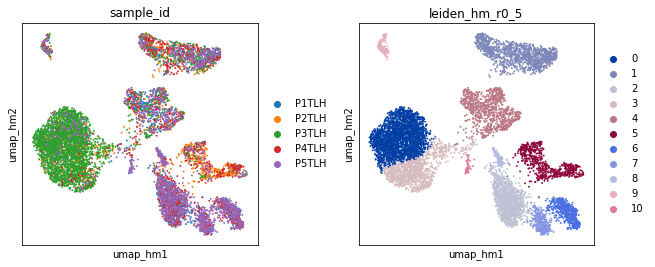

In [11]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(
    ad, basis='umap_hm', wspace=0.3,
    color=['sample_id', 'leiden_hm_r0_5'])

# Annotate

In [12]:
# https://www.nature.com/articles/s41467-018-06318-7 table S2
markers = 'HSD11B1 CD2 BCHE S100A8 SCD CES1 IGLC2 CD7 GNLY CD5L MGP CLEC1B PRSS23 CYP2A7 HPD MS4A1 FXYD2 STMN1 HBA1 ACTA2'.split()

# https://www.nature.com/articles/s41467-018-06318-7 fig 2
full_markers = '''
CYP3A7 CYP2A7 CYP2A6 SCD HMGCS1 ACSS2 TM7SF2 SEC16B SLBP RND3 PCK1 BCHE G6PC GHR ALDH6A1 RPP25L HSD11B1 HAMP GHR HPR GSTA2 AKR1C1 MASP2
MGP SPARCL1 TM4SF1 CLEC14A CCL14 CLEC1B FCN2 S100A13 RAMP3 INMT DNASE1L3 LIFR
KRT7 KRT19 SOX9 EPCAM
ACTA2 COL1A1 RBP1
S100A8 LYZ S100A9 HLA-DPB1 CD5L MARCO VSIG4
CD2 CD3D TRAC GZMK
CD7 KLRB1 NKG7
GNLY PTGDS GZMB TRDC STMN1 HMGB2 TYMS
MS4A1 LTB CD37 CD79B IGLC2 IGHG1 IGKC
HBB CA1 ALAS2
'''.split()

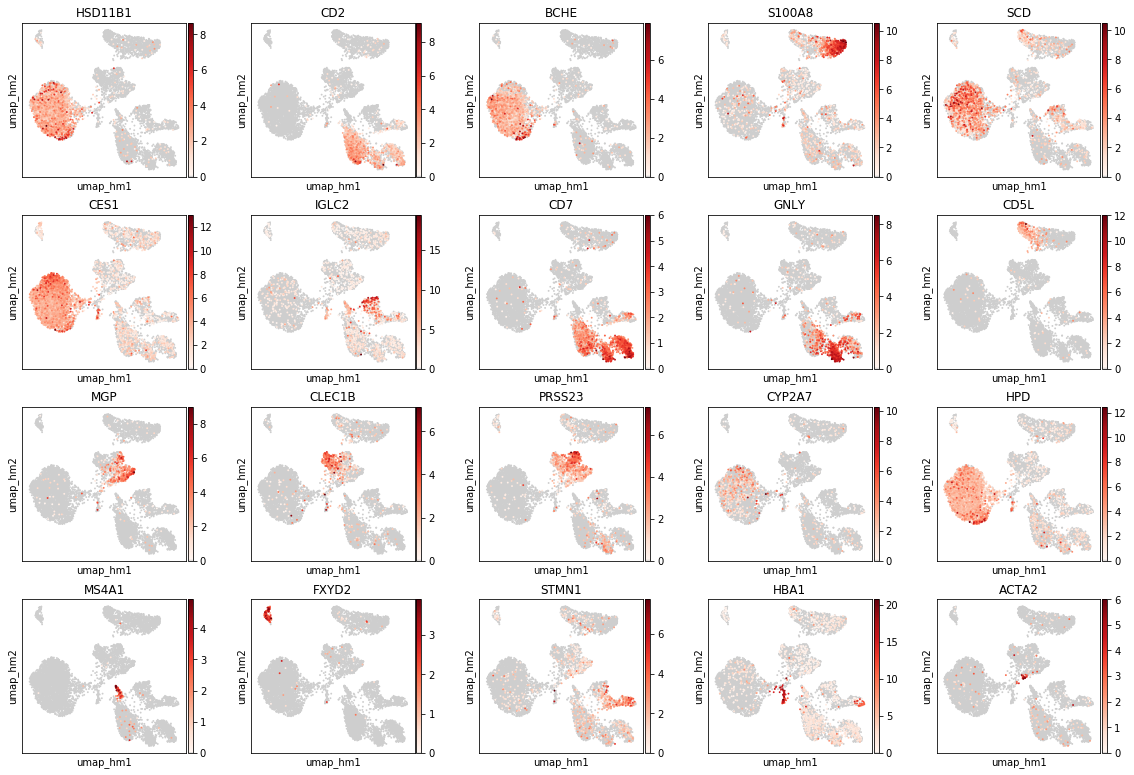

In [14]:
ss.lib.set_figsize((3, 3))
ss.lib.plot_scatter(ad, basis='umap_hm', color=markers, ncols=5, color_map=expr_cmap)

In [16]:
ss.lib.leiden(ad, use_graph='neighbors_hm', restrict_to=('leiden_hm_r0_5', ['5']), resolution=[0.1], key_added='hm_split')
ss.lib.leiden(ad, use_graph='neighbors_hm', restrict_to=('leiden_hm_split_r0_1', ['4']), resolution=[0.3], key_added='hm_split2')
ss.lib.leiden(ad, use_graph='neighbors_hm', restrict_to=('leiden_hm_split2_r0_3', ['1']), resolution=[0.1], key_added='hm_split3')

['leiden_hm_split3_r0_1']

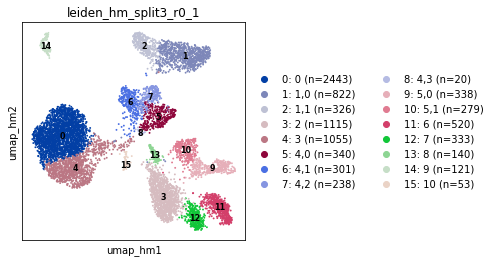

In [17]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_split3_r0_1')

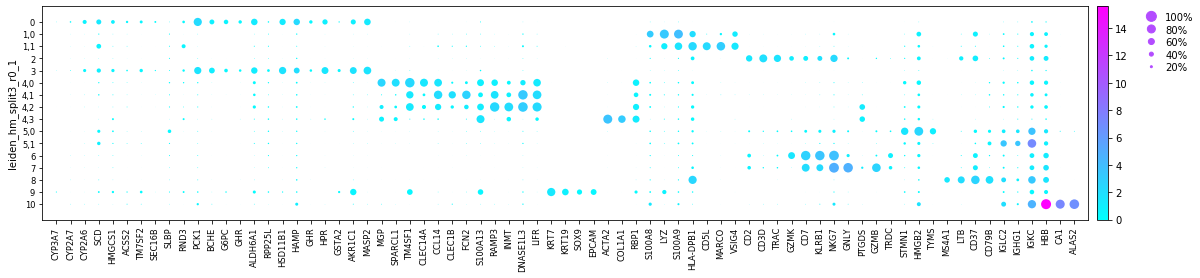

In [18]:
_ = sc.pl.dotplot(ad, full_markers, groupby='leiden_hm_split3_r0_1', figsize=(20, 4), color_map='cool')

In [19]:
# According to https://www.nature.com/articles/s41467-018-06318-7 Fig.2
celltype_mapping = {
    'Hepatocyte': ['0', '3'],
    'LSEC 1': ['4,0'],
    'LSEC 2,3': ['4,1'],
    'Portal endothelial': ['4,2'],
    'Cholangiocyte': ['9'],
    'Stellate': ['4,3'],
    'Inflammatory Macs': ['1,0'],
    'Non-inflammatory Macs': ['1,1'],
    'abT cell': ['2'],
    'NK-like': ['6'],
    'gdT cell 1': ['7'],
    'gdT cell 2': ['5,0'],
    'B cell': ['8'],
    'Plasma': ['5,1'],
    'Erythroid': ['10'],
}
broadcelltype_mapping = {
    'Hepatocyte': ['0', '3'],
    'Endothelial': ['4,0', '4,1', '4,2'],
    'Cholangiocyte': ['9'],
    'Stellate': ['4,3'],
    'Kupffer': ['1,0', '1,1'],
    'T/NK-cell': ['2', '7', '5,0', '6'],
    'B-cell': ['8', '5,1'],
    'Erythroid': ['10'],
}

In [20]:
ad.obs['CellType'] = ss.lib.regroup(ad, 'leiden_hm_split3_r0_1', celltype_mapping)

In [21]:
ad.obs['BroadCellType'] = ss.lib.regroup(ad, 'leiden_hm_split3_r0_1', broadcelltype_mapping)

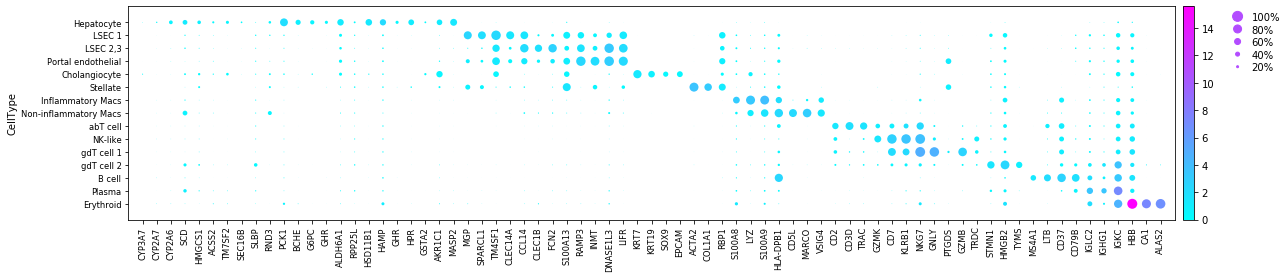

In [22]:
_ = sc.pl.dotplot(ad, full_markers, groupby='CellType', figsize=(20, 4), color_map='cool')

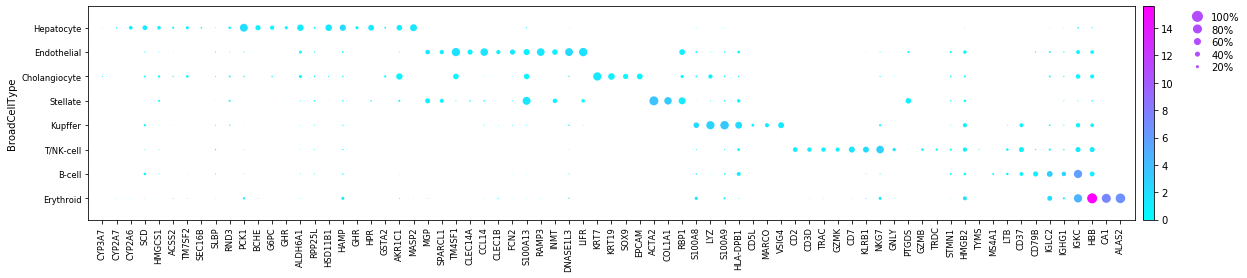

In [23]:
_ = sc.pl.dotplot(ad, full_markers, groupby='BroadCellType', figsize=(20, 4), color_map='cool')

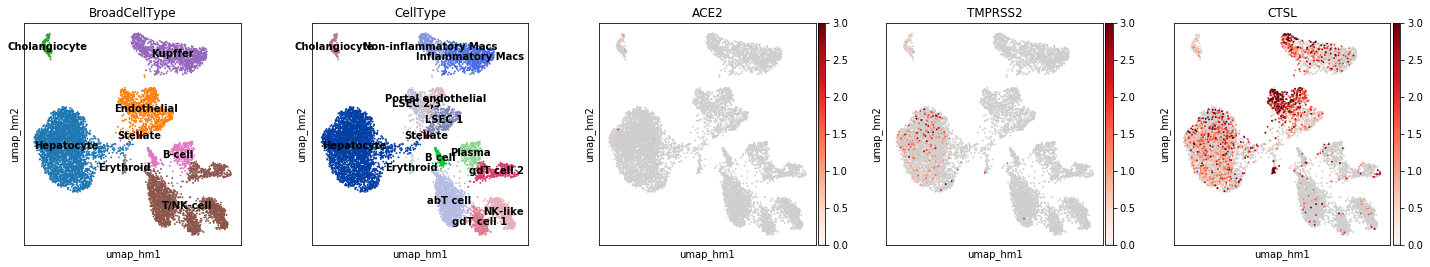

In [28]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(ad, basis='umap_hm', color=['BroadCellType', 'CellType', 'ACE2', 'TMPRSS2', 'CTSL'], color_map=expr_cmap, legend_loc='on data', vmax=3, ncols=5)

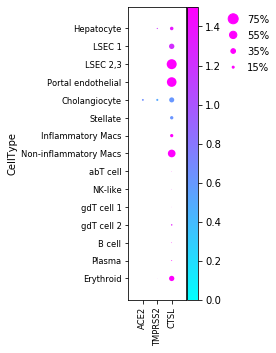

In [25]:
_ = sc.pl.dotplot(ad, ['ACE2', 'TMPRSS2', 'CTSL'], groupby='CellType', mean_only_expressed=True, vmin=0, vmax=1.5, dot_max=0.75, color_map='cool')

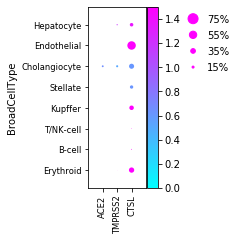

In [26]:
_ = sc.pl.dotplot(ad, ['ACE2', 'TMPRSS2', 'CTSL'], groupby='BroadCellType', mean_only_expressed=True, vmin=0, vmax=1.5, dot_max=0.75, color_map='cool')